# **Modelling**

In [1]:
# %pip install tensorflow-gpu==2.10.0
# %pip install scikit-learn==0.22

# Check for GPU

In [2]:
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If there is something in the list, a GPU is ready to be used.

# Load Data

In [3]:
source = '../data/Rice_Leaf_AUG/Rice_Leaf_AUG'
train_dir = '../data/train'
val_dir = '../data/val'
test_dir = '../data/test'

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(

    source,
    validation_split=0,
    label_mode = 'int',
    seed=0,
    batch_size=None

)

Found 11790 files belonging to 9 classes.


# Get Class Names

In [5]:
class_names = dataset.class_names
print(f'Class names: {class_names}')

Class names: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Neck_Blast', 'Rice Hispa', 'Sheath Blight']


# Exclude Some Classes

Some classes need to be excluded because of research purposes

In [6]:
exclude = ['Neck_Blast', 'Rice Hispa']

class_names = [classes for classes in class_names if classes not in exclude]
print(f'Class names: {class_names}')

Class names: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Sheath Blight']


# Data Preprocessing

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
train_ds = train_datagen.flow_from_directory(train_dir, 
    class_mode='sparse',
    target_size = (256, 256),
    classes = class_names)

val_ds = val_datagen.flow_from_directory(val_dir, 
    class_mode='sparse',
    target_size = (256, 256),
    shuffle=False,
    classes = class_names)

test_ds = test_datagen.flow_from_directory(test_dir, 
    class_mode='sparse',
    target_size = (256, 256),
    shuffle=False,
    classes = class_names)

Found 7682 images belonging to 7 classes.
Found 857 images belonging to 7 classes.
Found 952 images belonging to 7 classes.


# Model Creation

## Define model

We're going to try to use DenseNet121 first, the smallest safe model based on model_checking

In [9]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable=False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(7, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0005), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Set callback

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Train model

In [11]:
history = model.fit(train_ds, batch_size = 32, epochs=50, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/50
241/241 [==============================] - 132s 516ms/step - loss: 1.1551 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.7742 - val_sparse_categorical_accuracy: 0.7083
Epoch 2/50
241/241 [==============================] - 129s 536ms/step - loss: 0.8858 - sparse_categorical_accuracy: 0.6821 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.7655
Epoch 3/50
241/241 [==============================] - 115s 477ms/step - loss: 0.8044 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.6165 - val_sparse_categorical_accuracy: 0.7748
Epoch 4/50
241/241 [==============================] - 116s 482ms/step - loss: 0.7450 - sparse_categorical_accuracy: 0.7273 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.7106
Epoch 5/50
241/241 [==============================] - 114s 473ms/step - loss: 0.7068 - sparse_categorical_accuracy: 0.7406 - val_loss: 0.6087 - val_sparse_categorical_accuracy: 0.7620
Epoch 6/50
241/241 [==============================] - 116s 482ms/step - loss: 0.

## Create loss plot

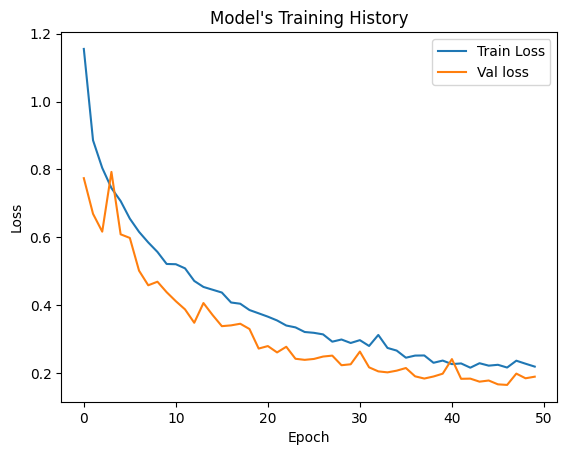

In [12]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Val loss')
plt.title('Model\'s Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict

In [13]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_pred

30/30 [==============================] - 9s 250ms/step


array([0, 0, 0, 0, 0, 0, 0, 5, 0, 3, 0, 0, 3, 0, 0, 4, 0, 0, 5, 0, 6, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 5, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 5, 1, 1, 1,
       1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [14]:
model.evaluate(test_ds)

30/30 [==============================] - 7s 228ms/step - loss: 0.2033 - sparse_categorical_accuracy: 0.9286


[0.2033223807811737, 0.9285714030265808]

## Evaluation

In [15]:
from sklearn.metrics import classification_report

print(classification_report(test_ds.labels, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.93      0.83      0.88       120
            Brown Spot       0.97      0.92      0.95       155
     Healthy Rice Leaf       0.97      1.00      0.99       109
            Leaf Blast       0.95      0.91      0.93       175
            Leaf scald       0.90      0.93      0.91       134
Narrow Brown Leaf Spot       0.77      0.96      0.86        96
         Sheath Blight       0.97      0.96      0.97       163

              accuracy                           0.93       952
             macro avg       0.92      0.93      0.93       952
          weighted avg       0.93      0.93      0.93       952



In [16]:
model.save_weights('../src/models/dense_net_model_weight.h5')